In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd() / "_scripts"))

In [3]:
import seaborn as sns
import seaborn.objects as so
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

from helpers.variable_interfaces import all_variables as vars
from setup.materials_setup import retrieve_cases
from setup.data_wrangle2 import *
from analysis.helpers import map_zone_names, extract_times
from analysis.plot_helpers import set_axis_ticks
# from analysis.dataframes import *
# from analysis.volumes import *
from analysis2.all_cases_v_time import *
sns.set_style("darkgrid")

import polars.selectors as cs
import matplotlib.ticker as ticker

In [4]:
cases = retrieve_cases()

In [5]:
medium_cases = [i for i in cases if "Medium" in i.case_name]
[case] = [i for i in medium_cases if "bol" in i.case_name]
case

CaseData(case_name='Medium_case_bol_5', idf=<geomeppy.idf.IDF object at 0x14059eaa0>, sql=Energy SQLiteResult: /Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/geomeppy/cases/material_exp/Medium_case_bol_5/results/eplusout.sql, path_to_input=PosixPath('/Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/svg2plan/outputs2/case_bol_5'), path_to_output=PosixPath('/Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/geomeppy/cases/material_exp/Medium_case_bol_5'))

In [6]:
av = vars.afn
qois = [
    av.linkage["flow12"],
    av.linkage["flow21"],
]

df = create_wide_dataframe_for_many_qois(case, qois)
df = extract_times(df)
df.head(2)

case_names,space_names,datetimes,AFN Linkage Node 1 to Node 2 Volume Flow Rate [m3/s],AFN Linkage Node 2 to Node 1 Volume Flow Rate [m3/s],time
str,str,datetime[μs],f64,f64,str
"""Medium_case_bol_5""","""BLOCK 06 STOREY 0 WALL 0002_1 …",2017-07-01 00:00:00,0.0,0.613877,"""00:00"""
"""Medium_case_bol_5""","""BLOCK 06 STOREY 0 WALL 0002_1 …",2017-07-01 00:15:00,0.000248,0.560061,"""00:15"""


In [8]:
df = df.with_columns(net_linkage=pl.col("AFN Linkage Node 1 to Node 2 Volume Flow Rate [m3/s]") - pl.col("AFN Linkage Node 2 to Node 1 Volume Flow Rate [m3/s]") ) # TODO 
df.head()

case_names,space_names,datetimes,AFN Linkage Node 1 to Node 2 Volume Flow Rate [m3/s],AFN Linkage Node 2 to Node 1 Volume Flow Rate [m3/s],time,net_linkage
str,str,datetime[μs],f64,f64,str,f64
"""Medium_case_bol_5""","""BLOCK 06 STOREY 0 WALL 0002_1 …",2017-07-01 00:00:00,0.0,0.613877,"""00:00""",-0.613877
"""Medium_case_bol_5""","""BLOCK 06 STOREY 0 WALL 0002_1 …",2017-07-01 00:15:00,0.000248,0.560061,"""00:15""",-0.559813
"""Medium_case_bol_5""","""BLOCK 06 STOREY 0 WALL 0002_1 …",2017-07-01 00:30:00,0.005882,0.479654,"""00:30""",-0.473772
"""Medium_case_bol_5""","""BLOCK 06 STOREY 0 WALL 0002_1 …",2017-07-01 00:45:00,0.020876,0.416761,"""00:45""",-0.395885
"""Medium_case_bol_5""","""BLOCK 06 STOREY 0 WALL 0002_1 …",2017-07-01 01:00:00,0.002984,0.400927,"""01:00""",-0.397943


In [ ]:
def get_zones(name):
    return " ".join(name.split(" ")[0:2])

def get_surface_type(name):
    stype = name.split(" ")[-1]
    if stype == "DOOR" or stype == "WINDOW":
        return stype
    return "AIRBOUNDARY"

df = df.with_columns(zone_names=pl.col("space_names").map_elements(get_zones, return_dtype=pl.String))
df = df.with_columns(surface_types=pl.col("space_names").map_elements(get_surface_type, return_dtype=pl.String))
df.head(2)

case_names,space_names,datetimes,AFN Linkage Node 1 to Node 2 Volume Flow Rate [m3/s],AFN Linkage Node 2 to Node 1 Volume Flow Rate [m3/s],time,net_linkage,zone_names,surface_types
str,str,datetime[μs],f64,f64,str,f64,str,str
"""Medium_case_bol_5""","""BLOCK 06 STOREY 0 WALL 0002_1 …",2017-07-01 00:00:00,0.0,0.613877,"""00:00""",-0.613877,"""BLOCK 06""","""DOOR"""
"""Medium_case_bol_5""","""BLOCK 06 STOREY 0 WALL 0002_1 …",2017-07-01 00:15:00,0.000248,0.560061,"""00:15""",-0.559813,"""BLOCK 06""","""DOOR"""


In [39]:
linkages = "AFN Linkage Node 1 to Node 2 Volume Flow Rate [m3/s]", "AFN Linkage Node 2 to Node 1 Volume Flow Rate [m3/s]"

df_long_og = df.unpivot(index=["datetimes", "zone_names", "time", "space_names"], on=linkages, variable_name="linkage12or21", value_name="flow_rate")
df_long_og

datetimes,zone_names,time,space_names,linkage12or21,flow_rate
datetime[μs],str,str,str,str,f64
2017-07-01 00:00:00,"""BLOCK 06""","""00:00""","""BLOCK 06 STOREY 0 WALL 0002_1 …","""AFN Linkage Node 1 to Node 2 V…",0.0
2017-07-01 00:15:00,"""BLOCK 06""","""00:15""","""BLOCK 06 STOREY 0 WALL 0002_1 …","""AFN Linkage Node 1 to Node 2 V…",0.000248
2017-07-01 00:30:00,"""BLOCK 06""","""00:30""","""BLOCK 06 STOREY 0 WALL 0002_1 …","""AFN Linkage Node 1 to Node 2 V…",0.005882
2017-07-01 00:45:00,"""BLOCK 06""","""00:45""","""BLOCK 06 STOREY 0 WALL 0002_1 …","""AFN Linkage Node 1 to Node 2 V…",0.020876
2017-07-01 01:00:00,"""BLOCK 06""","""01:00""","""BLOCK 06 STOREY 0 WALL 0002_1 …","""AFN Linkage Node 1 to Node 2 V…",0.002984
…,…,…,…,…,…
2017-07-01 22:45:00,"""BLOCK 06""","""22:45""","""BLOCK 06 STOREY 0 WALL 0001_1""","""AFN Linkage Node 2 to Node 1 V…",0.003264
2017-07-01 23:00:00,"""BLOCK 06""","""23:00""","""BLOCK 06 STOREY 0 WALL 0001_1""","""AFN Linkage Node 2 to Node 1 V…",0.008754
2017-07-01 23:15:00,"""BLOCK 06""","""23:15""","""BLOCK 06 STOREY 0 WALL 0001_1""","""AFN Linkage Node 2 to Node 1 V…",0.01322


In [ ]:

df_long = df.unpivot(index=["datetimes", "zone_names", "time", "surface_types"], on=linkages, variable_name="linkage12or21", value_name="flow_rate")

df_zones_long = df_long.group_by(["zone_names", "time", "datetimes", "linkage12or21"]).agg(pl.col("flow_rate").sum()).sort(by=["datetimes","zone_names"])
df_zones_long.head(2)

# TODO check that doing correct agg.. 

zone_names,time,datetimes,linkage12or21,flow_rate
str,str,datetime[μs],str,f64
"""BLOCK 00""","""00:00""",2017-07-01 00:00:00,"""AFN Linkage Node 1 to Node 2 V…",0.007564
"""BLOCK 00""","""00:00""",2017-07-01 00:00:00,"""AFN Linkage Node 2 to Node 1 V…",0.62143


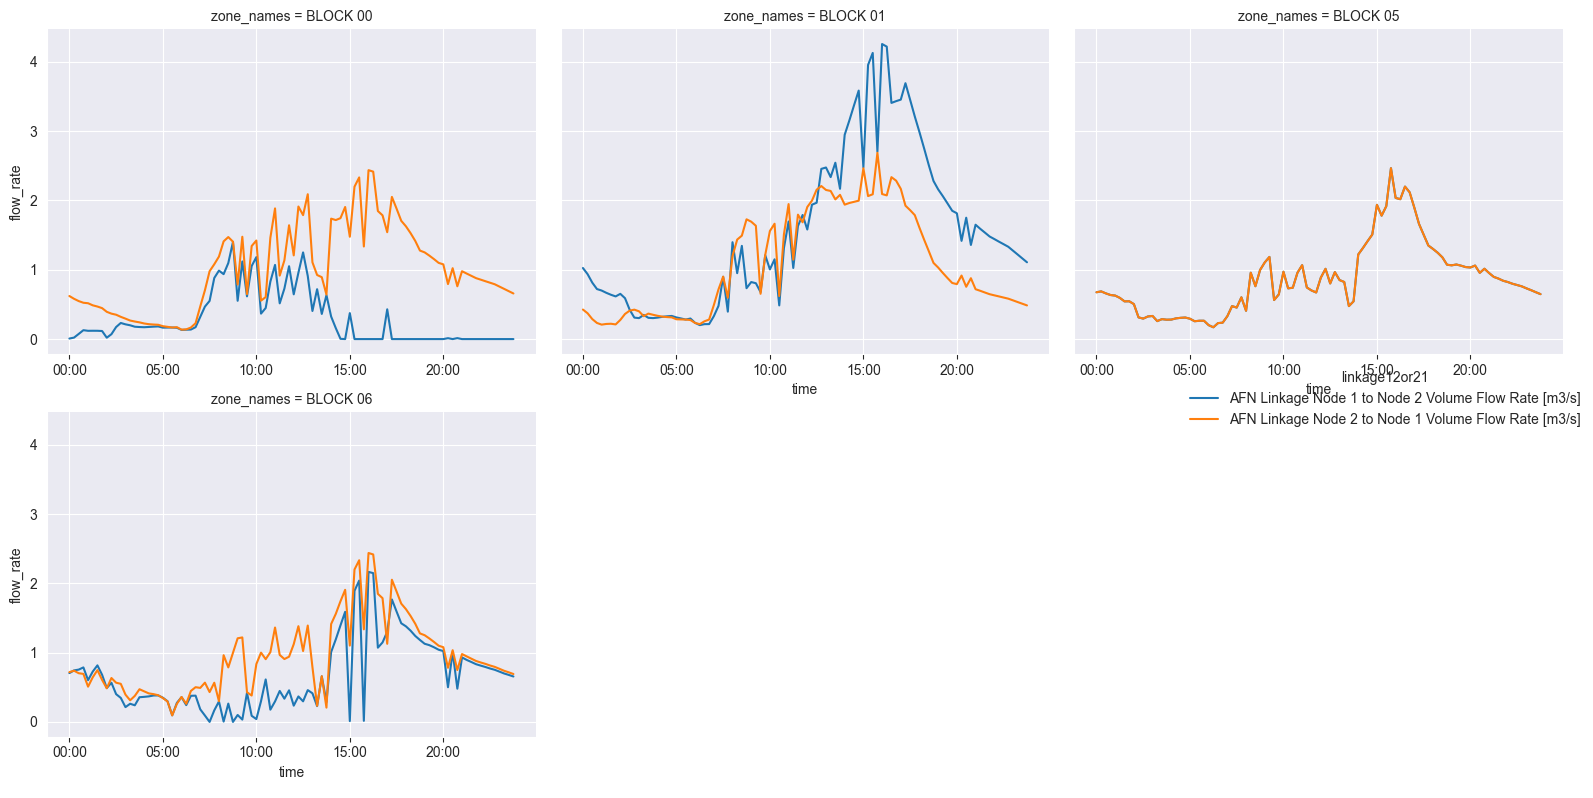

In [13]:
g = sns.relplot(df_zones_long, x="time", y="flow_rate",  col="zone_names", col_wrap=3, height=4,  kind="line", errorbar=None, hue="linkage12or21", hue_order=linkages,)
for ax in g.axes.flat:
    ax.xaxis.set_ticks_position("bottom")
    ax.xaxis.set_major_locator(ticker.AutoLocator())
g.add_legend(loc="lower right")

In [14]:
df_zones = df.group_by(["zone_names", "time", "datetimes" ]).agg(pl.col("net_linkage").sum()).sort(by="datetimes")

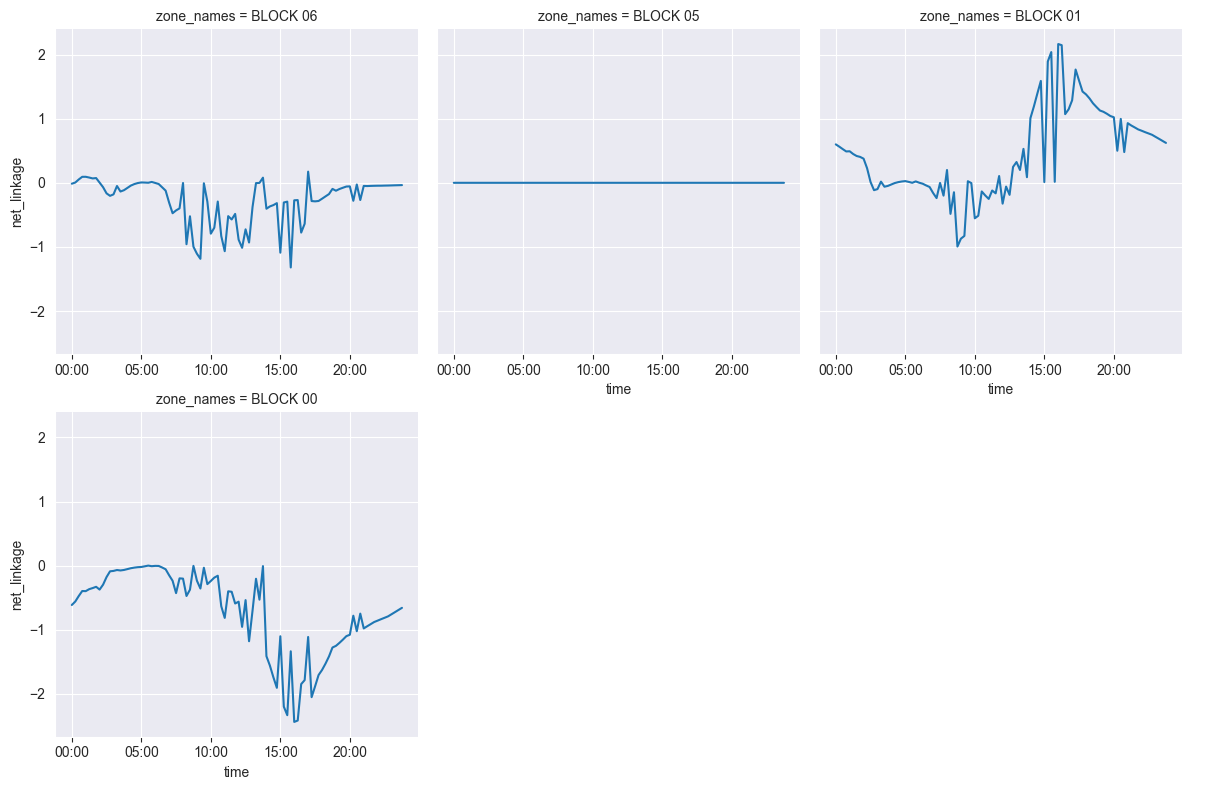

In [15]:
g = sns.relplot(df_zones, x="time", y="net_linkage",  col="zone_names", col_wrap=3, height=4,  kind="line", errorbar=None, )
for ax in g.axes.flat:
    ax.xaxis.set_ticks_position("bottom")
    ax.xaxis.set_major_locator(ticker.AutoLocator())
g.add_legend(loc="lower right")

In [31]:
df_long

datetimes,zone_names,time,surface_types,linkage12or21,flow_rate
datetime[μs],str,str,str,str,f64
2017-07-01 00:00:00,"""BLOCK 06""","""00:00""","""DOOR""","""AFN Linkage Node 1 to Node 2 V…",0.0
2017-07-01 00:15:00,"""BLOCK 06""","""00:15""","""DOOR""","""AFN Linkage Node 1 to Node 2 V…",0.000248
2017-07-01 00:30:00,"""BLOCK 06""","""00:30""","""DOOR""","""AFN Linkage Node 1 to Node 2 V…",0.005882
2017-07-01 00:45:00,"""BLOCK 06""","""00:45""","""DOOR""","""AFN Linkage Node 1 to Node 2 V…",0.020876
2017-07-01 01:00:00,"""BLOCK 06""","""01:00""","""DOOR""","""AFN Linkage Node 1 to Node 2 V…",0.002984
…,…,…,…,…,…
2017-07-01 22:45:00,"""BLOCK 06""","""22:45""","""AIRBOUNDARY""","""AFN Linkage Node 2 to Node 1 V…",0.003264
2017-07-01 23:00:00,"""BLOCK 06""","""23:00""","""AIRBOUNDARY""","""AFN Linkage Node 2 to Node 1 V…",0.008754
2017-07-01 23:15:00,"""BLOCK 06""","""23:15""","""AIRBOUNDARY""","""AFN Linkage Node 2 to Node 1 V…",0.01322


In [44]:
df_stype_long = df_long.drop("zone_names").group_by(["surface_types", "time", "datetimes", "linkage12or21"]).agg(pl.col("flow_rate").mean()).sort(by=["datetimes"])
df_stype_long.head(2)

surface_types,time,datetimes,linkage12or21,flow_rate
str,str,datetime[μs],str,f64
"""WINDOW""","""00:00""",2017-07-01 00:00:00,"""AFN Linkage Node 1 to Node 2 V…",0.230991
"""AIRBOUNDARY""","""00:00""",2017-07-01 00:00:00,"""AFN Linkage Node 2 to Node 1 V…",0.104675


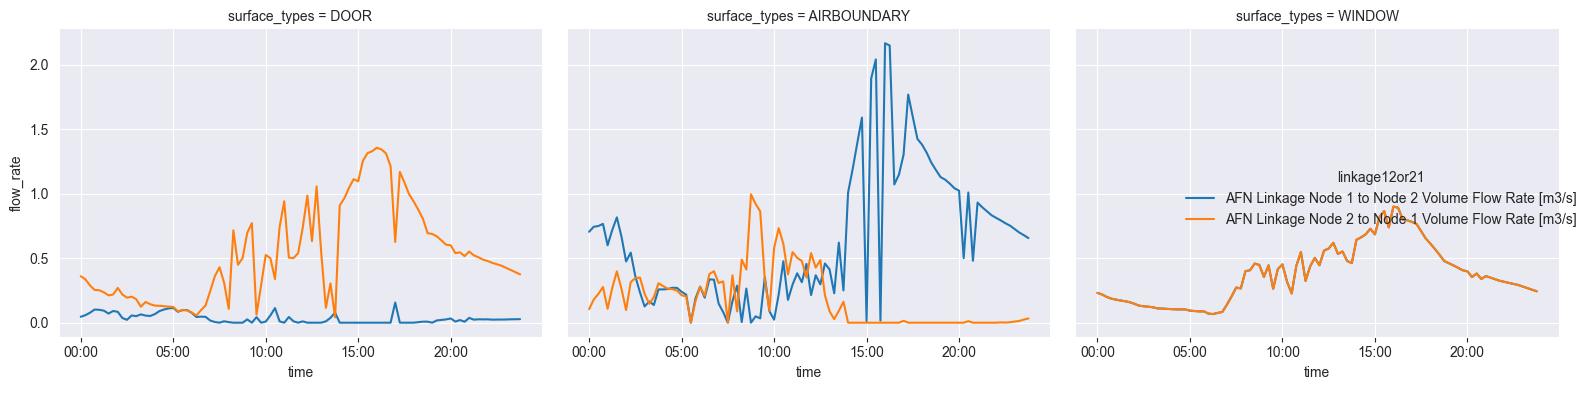

In [42]:
g = sns.relplot(df_stype_long, x="time", y="flow_rate",  col="surface_types", col_wrap=3, height=4,  kind="line", errorbar=None, hue="linkage12or21", hue_order=linkages,)
for ax in g.axes.flat:
    ax.xaxis.set_ticks_position("bottom")
    ax.xaxis.set_major_locator(ticker.AutoLocator())
g.add_legend(loc="lower right")

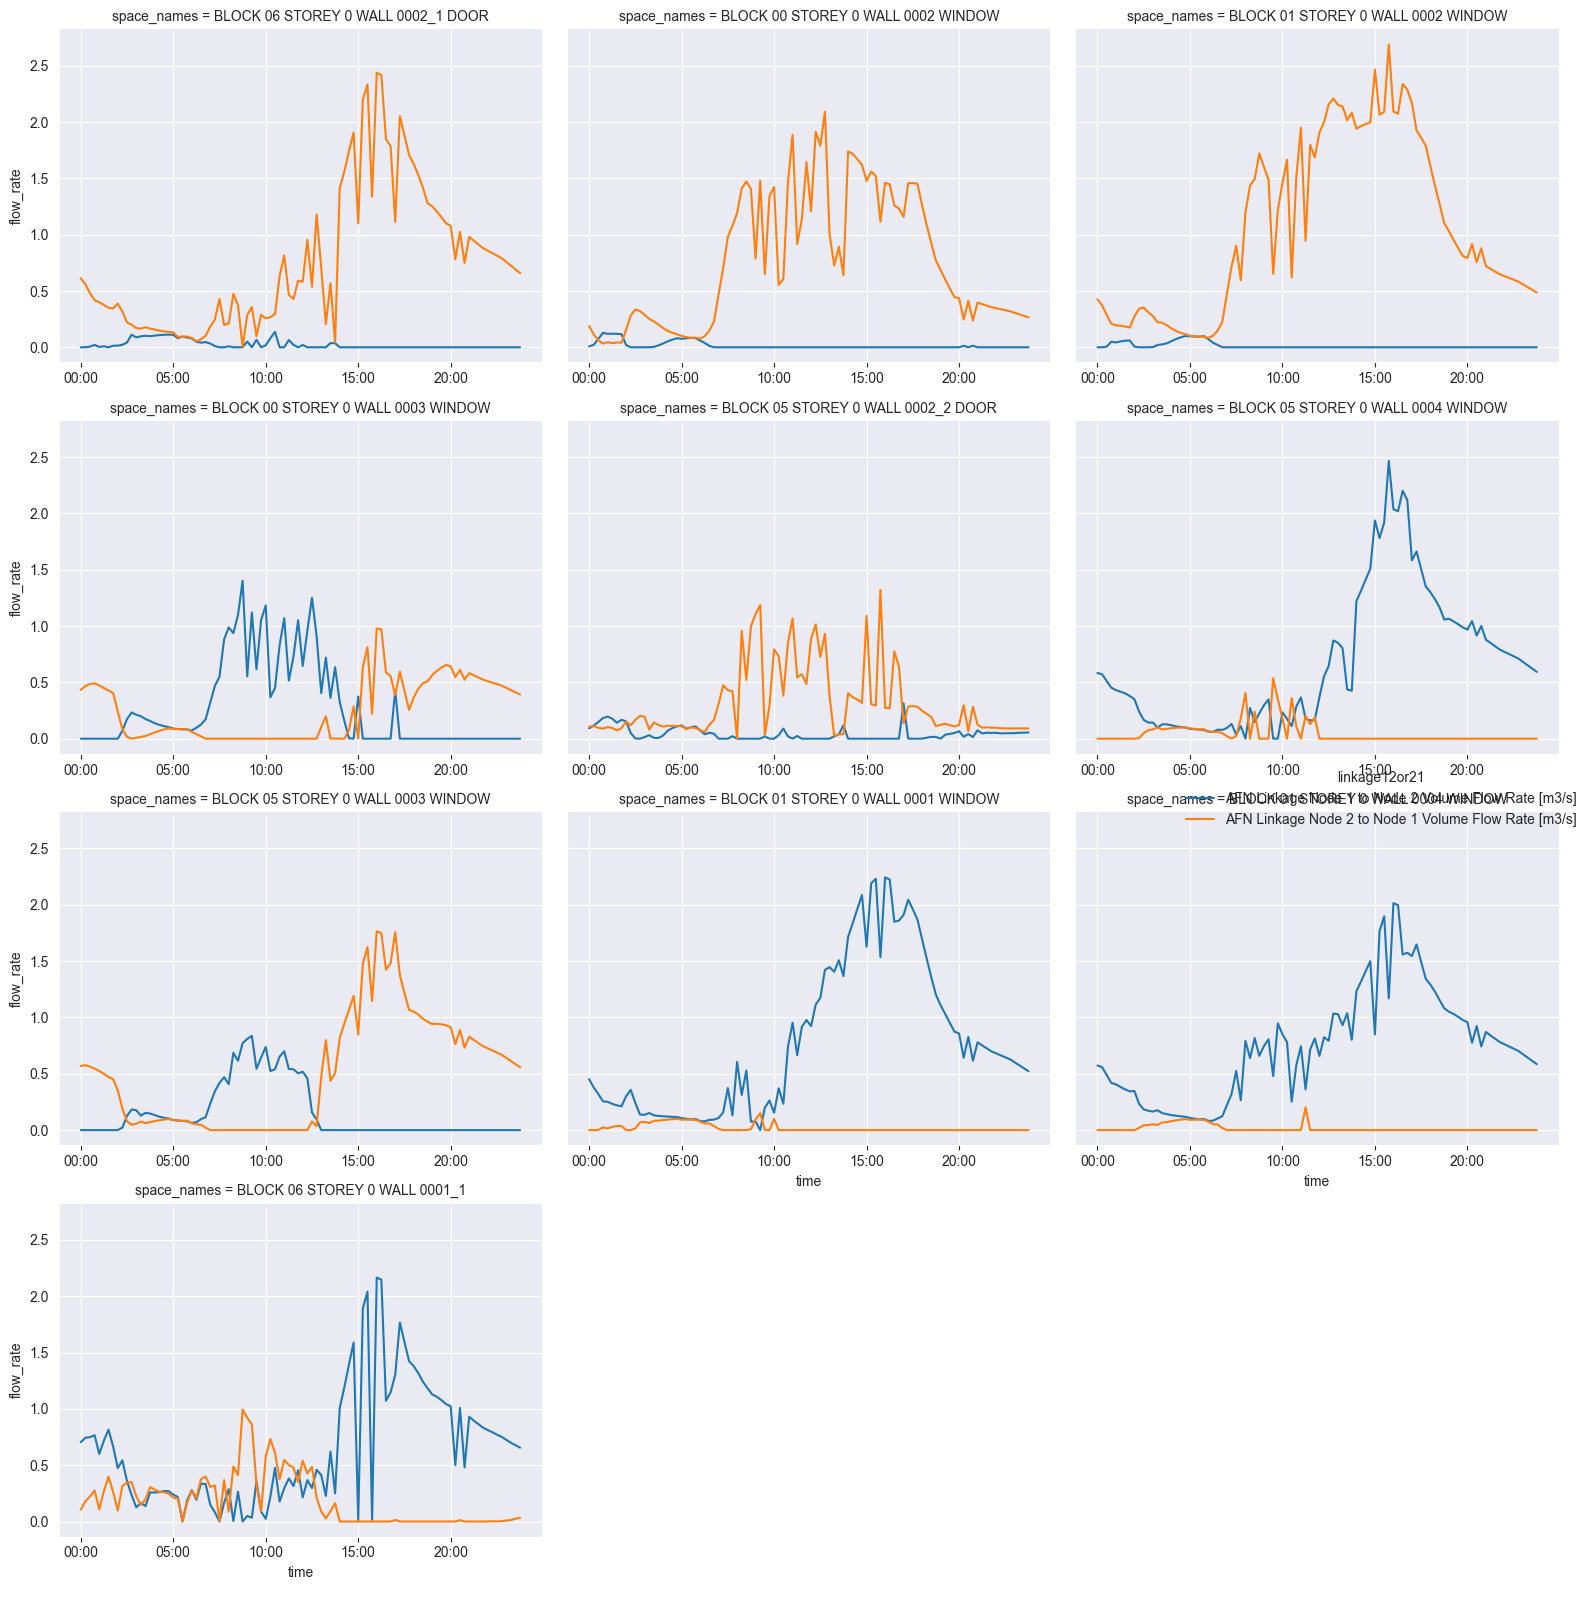

In [40]:
g = sns.relplot(df_long_og, x="time", y="flow_rate",  col="space_names", col_wrap=3, height=4,  kind="line", errorbar=None, hue="linkage12or21", hue_order=linkages,)
for ax in g.axes.flat:
    ax.xaxis.set_ticks_position("bottom")
    ax.xaxis.set_major_locator(ticker.AutoLocator())
g.add_legend(loc="lower right")

In [16]:
# TODO consider also, summing inflow vs outflow for windows vs doors, vs accumulating at zone level ~ to represent the mixing and ventilation volume variables